In [33]:
# this notebook preprocesses the data to feed it to a forcasting model

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
data = pd.read_csv("../data/COVID19_timeseries.csv")

In [36]:
data.head()

,country,date,infections,Lat,Long,deaths,recovered,Continent,bed_occupancy,ICU_beds,Population,population_world,age_0_to_64,age_15_to_64,age_over_65,month,day
0,Australia,1/24/20,0,-24.502867,141.055589,0,0,Oceania,NaN,NaN,25649909.0,0.0033,0.19,0.655,0.155,1.0,24.0
1,Australia,1/25/20,0,-24.502867,141.055589,0,0,Oceania,NaN,NaN,25649909.0,0.0033,0.19,0.655,0.155,1.0,25.0
2,Australia,1/26/20,4,-24.502867,141.055589,0,0,Oceania,NaN,NaN,25649909.0,0.0033,0.19,0.655,0.155,1.0,26.0
3,Australia,1/27/20,5,-24.502867,141.055589,0,0,Oceania,NaN,NaN,25649909.0,0.0033,0.19,0.655,0.155,1.0,27.0
4,Australia,1/28/20,5,-24.502867,141.055589,0,0,Oceania,NaN,NaN,25649909.0,0.0033,0.19,0.655,0.155,1.0,28.0


In [37]:
data.shape

(1887, 17)

In [38]:
# add country as index
data = data.set_index('country')

In [39]:
# dummy encode the 'Continent' column
data = pd.concat([data, pd.get_dummies(data['Continent'])], axis=1).drop('Continent', axis=1)

In [40]:
# drop the date and population column 
dates = data.date
data = data.drop(['date', 'Population', 'deaths', 'recovered'], axis=1)

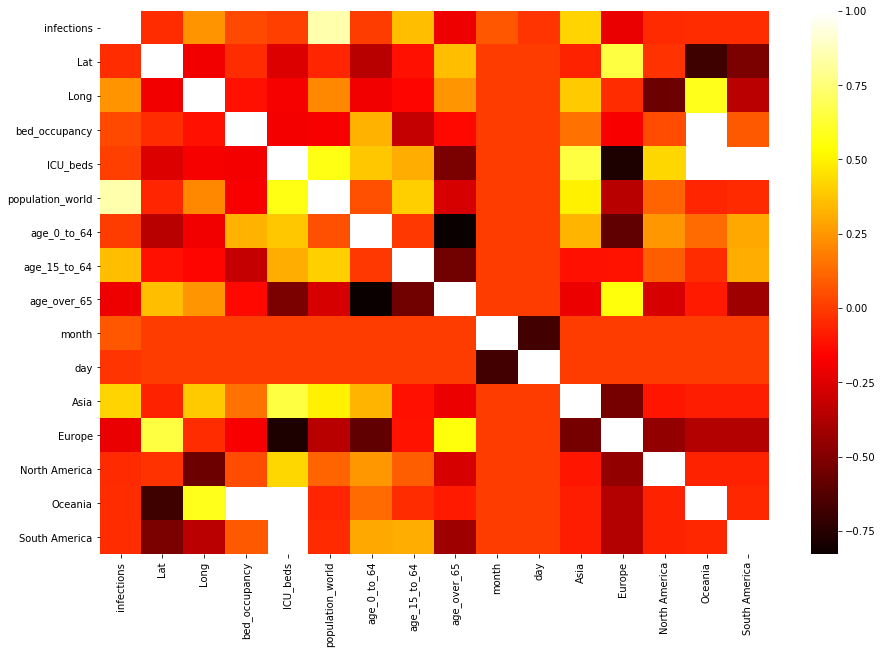

In [41]:
# visualize correlations between columns
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 10)
sns.heatmap(data.corr(), cmap='hot', ax=ax)

In [42]:
# bed_occupancy and ICU_beds contain NaNs values
# KNN impute both columns

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)

In [43]:
imputer.fit(data)

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=3, weights='uniform')

In [44]:
data = pd.DataFrame(imputer.transform(data), columns=data.columns, index=data.index)

In [45]:
# set country as index
data.head()

,infections,Lat,Long,bed_occupancy,ICU_beds,population_world,age_0_to_64,age_15_to_64,age_over_65,month,day,Asia,Europe,North America,Oceania,South America
country,,,,,,,,,,,,,,,,
Australia,0.0,-24.502867,141.055589,0.755,46.0,0.0033,0.19,0.655,0.155,1.0,24.0,0.0,0.0,0.0,1.0,0.0
Australia,0.0,-24.502867,141.055589,0.755,46.0,0.0033,0.19,0.655,0.155,1.0,25.0,0.0,0.0,0.0,1.0,0.0
Australia,4.0,-24.502867,141.055589,0.755,46.0,0.0033,0.19,0.655,0.155,1.0,26.0,0.0,0.0,0.0,1.0,0.0
Australia,5.0,-24.502867,141.055589,0.755,46.0,0.0033,0.19,0.655,0.155,1.0,27.0,0.0,0.0,0.0,1.0,0.0
Australia,5.0,-24.502867,141.055589,0.755,46.0,0.0033,0.19,0.655,0.155,1.0,28.0,0.0,0.0,0.0,1.0,0.0


In [46]:
# use Netherlands as test data series and Belgium as validation series
data_nl = data[data.index == "Netherlands"]
data_bel = data[data.index == "Belgium"]

In [47]:
# drop test and validation data from train data
data = data.drop(['Netherlands', 'Belgium'])

In [48]:
data_nl.head()

,infections,Lat,Long,bed_occupancy,ICU_beds,population_world,age_0_to_64,age_15_to_64,age_over_65,month,day,Asia,Europe,North America,Oceania,South America
country,,,,,,,,,,,,,,,,
Netherlands,0.0,52.1326,5.2913,0.654,6.4,0.00224,0.164,0.648,0.188,1.0,24.0,0.0,1.0,0.0,0.0,0.0
Netherlands,0.0,52.1326,5.2913,0.654,6.4,0.00224,0.164,0.648,0.188,1.0,25.0,0.0,1.0,0.0,0.0,0.0
Netherlands,0.0,52.1326,5.2913,0.654,6.4,0.00224,0.164,0.648,0.188,1.0,26.0,0.0,1.0,0.0,0.0,0.0
Netherlands,0.0,52.1326,5.2913,0.654,6.4,0.00224,0.164,0.648,0.188,1.0,27.0,0.0,1.0,0.0,0.0,0.0
Netherlands,0.0,52.1326,5.2913,0.654,6.4,0.00224,0.164,0.648,0.188,1.0,28.0,0.0,1.0,0.0,0.0,0.0


In [49]:
n_countries = 35
n_timesteps = 51
n_features = len(data.columns)

In [50]:
# create the labels by shifting the 'infections' column to the left
# make sure to create labels before scaling the data!
y_train = data.values[:, 0].copy()
y_val = data_bel.values[:, 0].copy()
y_test = data_nl.values[:, 0].copy()

In [51]:
# create scaler and fit on training data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler.fit(data)

In [52]:
# scale all data
#data = scaler.transform(data)
#data_bel = scaler.transform(data_bel)
#data_nl = scaler.transform(data_nl)

In [53]:
# add original infections back to data
#data[:, 0] = y_train
#data_bel[:, 0] = y_val
#data_nl[:, 0] = y_test

In [54]:
data = data.values
data_bel = data_bel.values
data_nl = data_nl.values

In [55]:
# reshape data to appropriate 3D timeseries data
x_train = np.reshape(data, (n_countries, n_timesteps, n_features))

In [56]:
x_val = np.reshape(data_bel, (1, n_timesteps, n_features))
x_test = np.reshape(data_nl, (1, n_timesteps, n_features))

In [57]:
# reshape labels according to the data
y_train = np.reshape(y_train, (x_train.shape[0], x_train.shape[1], 1))
y_val = np.reshape(y_val, (x_val.shape[0], x_val.shape[1], 1))
y_test = np.reshape(y_test, (x_test.shape[0], x_test.shape[1], 1))

In [58]:
# to shift to left, remove first element
y_train = y_train[:, 1:]
y_val = y_val[:, 1:]
y_test = y_test[:, 1:]

# add outer dimension to match dimensionality of data
#y_train = np.expand_dims(y_train, axis=2)
#y_val = np.expand_dims(y_val, axis=2)
#y_test = np.expand_dims(y_test, axis=2)

In [59]:
# shift data to right by removing final timestep
x_train = x_train[:, :-1]
x_val = x_val[:, :-1]
x_test = x_test[:, :-1]

In [60]:
x_train.shape, x_val.shape, x_test.shape

((35, 50, 16), (1, 50, 16), (1, 50, 16))

In [61]:
y_train.shape, y_val.shape, y_test.shape

((35, 50, 1), (1, 50, 1), (1, 50, 1))

In [62]:
import tensorflow.keras as keras
# build and return a simple LSTM autoencoder in Keras
def build_model(n_features, embedding_size, learning_rate):
    # the input to the LSTM is a mini-batch (None) of a certain sequence length (50) of n_features (18)
    input_layer = keras.layers.Input(shape=(None, n_features))
    # return sequence of LSTM states
    hidden_sequences = keras.layers.LSTM(units=embedding_size, return_sequences=True)(input_layer)
    #hidden_sequences = keras.layers.SimpleRNN(units=embedding_size, return_sequences=True)(input_layer)
    
    # Output layer is 1 neuron for regression
    output_layer = keras.layers.Dense(units=1, activation='linear')(hidden_sequences)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), loss="MSE")
    
    return model

In [81]:
model = build_model(n_features, embedding_size=1000, learning_rate=0.002)

In [82]:
model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=n_countries, epochs=5000)

Train on 35 samples, validate on 1 samples
Epoch 1/5000
35/35 [==============================] - 3s 96ms/step - loss: 114204672.0000 - val_loss: 23325.0078
Epoch 2/5000
35/35 [==============================] - 0s 12ms/step - loss: 114199568.0000 - val_loss: 22951.4531
Epoch 3/5000
35/35 [==============================] - 0s 12ms/step - loss: 114195224.0000 - val_loss: 22637.4941
Epoch 4/5000
35/35 [==============================] - 0s 12ms/step - loss: 114190224.0000 - val_loss: 22324.7969
Epoch 5/5000
35/35 [==============================] - 0s 12ms/step - loss: 114186296.0000 - val_loss: 22004.1777
Epoch 6/5000
35/35 [==============================] - 0s 11ms/step - loss: 114180872.0000 - val_loss: 21688.3477
Epoch 7/5000
35/35 [==============================] - 0s 12ms/step - loss: 114175416.0000 - val_loss: 21395.9199
Epoch 8/5000
35/35 [==============================] - 0s 12ms/step - loss: 114170632.0000 - val_loss: 21141.5176
Epoch 9/5000
35/35 [==============================] -

Epoch 73/5000
35/35 [==============================] - 0s 12ms/step - loss: 113832736.0000 - val_loss: 12128.3047
Epoch 74/5000
35/35 [==============================] - 0s 13ms/step - loss: 113826264.0000 - val_loss: 12023.0820
Epoch 75/5000
35/35 [==============================] - 0s 12ms/step - loss: 113820272.0000 - val_loss: 11925.7500
Epoch 76/5000
35/35 [==============================] - 0s 12ms/step - loss: 113816248.0000 - val_loss: 11828.7324
Epoch 77/5000
35/35 [==============================] - 0s 12ms/step - loss: 113811912.0000 - val_loss: 11718.2734
Epoch 78/5000
35/35 [==============================] - 0s 12ms/step - loss: 113806376.0000 - val_loss: 11602.4004
Epoch 79/5000
35/35 [==============================] - 0s 12ms/step - loss: 113801736.0000 - val_loss: 11490.3447
Epoch 80/5000
35/35 [==============================] - 0s 12ms/step - loss: 113797112.0000 - val_loss: 11387.2529
Epoch 81/5000
35/35 [==============================] - 0s 12ms/step - loss: 113791800.00

Epoch 145/5000
35/35 [==============================] - 1s 14ms/step - loss: 113497704.0000 - val_loss: 6362.9775
Epoch 146/5000
35/35 [==============================] - 0s 13ms/step - loss: 113493232.0000 - val_loss: 6316.9487
Epoch 147/5000
35/35 [==============================] - 1s 14ms/step - loss: 113488768.0000 - val_loss: 6280.0840
Epoch 148/5000
35/35 [==============================] - 0s 13ms/step - loss: 113484328.0000 - val_loss: 6243.3989
Epoch 149/5000
35/35 [==============================] - 0s 13ms/step - loss: 113479760.0000 - val_loss: 6167.8276
Epoch 150/5000
35/35 [==============================] - 0s 11ms/step - loss: 113473720.0000 - val_loss: 6136.0596
Epoch 151/5000
35/35 [==============================] - 0s 14ms/step - loss: 113467944.0000 - val_loss: 6083.4248
Epoch 152/5000
35/35 [==============================] - 1s 15ms/step - loss: 113463472.0000 - val_loss: 6020.5332
Epoch 153/5000
35/35 [==============================] - 0s 12ms/step - loss: 113459000.0

Epoch 217/5000
35/35 [==============================] - 1s 15ms/step - loss: 113171192.0000 - val_loss: 3834.0510
Epoch 218/5000
35/35 [==============================] - 0s 13ms/step - loss: 113166808.0000 - val_loss: 3783.3862
Epoch 219/5000
35/35 [==============================] - 0s 13ms/step - loss: 113162384.0000 - val_loss: 3771.0120
Epoch 220/5000
35/35 [==============================] - 0s 12ms/step - loss: 113158032.0000 - val_loss: 3845.5825
Epoch 221/5000
35/35 [==============================] - 0s 12ms/step - loss: 113153632.0000 - val_loss: 3762.9922
Epoch 222/5000
35/35 [==============================] - 0s 12ms/step - loss: 113149224.0000 - val_loss: 3714.7520
Epoch 223/5000
35/35 [==============================] - 0s 12ms/step - loss: 113144848.0000 - val_loss: 3700.8057
Epoch 224/5000
35/35 [==============================] - 0s 12ms/step - loss: 113140448.0000 - val_loss: 3717.7898
Epoch 225/5000
35/35 [==============================] - 0s 13ms/step - loss: 113136088.0

KeyboardInterrupt: 

In [83]:
preds_nl = np.squeeze(model.predict(x_test))

In [84]:
# plot  predictions vs actual infections
def plot_preds_vs_actual(dates, predictions, labels):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,5)
    plt.xticks(ticks=[0, 50], labels=[dates.unique()[0], dates.unique()[50]])
    plt.ylabel('Infections')
    plt.xlabel('date')
    plt.title('Predicted infections versus actual infections in the Netherlands')
    sns.lineplot(data=np.squeeze(labels), ax=ax)
    sns.lineplot(data=predictions, ax=ax)
    plt.legend(['Actual', 'Predictions']) 

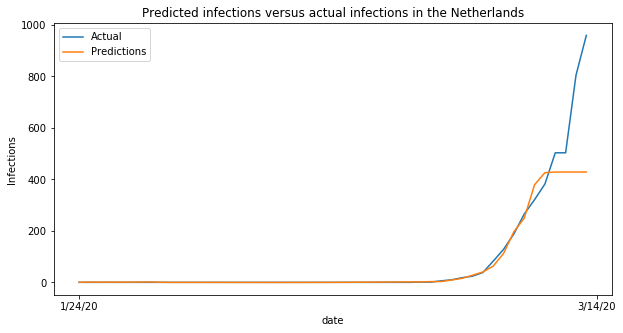

In [85]:
# show predictions vs actual infections
plot_preds_vs_actual(dates, preds_nl, y_test)

In [86]:
# predict until certain point, then add predictions to data to keep forecasting
def forecast(model, data, days_ahead):
    idx_infected = 0
    idx_day = 10
    idx_month = 9
    
    # do initial prediction
    preds = model.predict(data)
     
    for i in range(days_ahead):
        # take final prediction
        pred_new = preds[:, -1]
        # copy timeseries timestep 
        timestep_new = data[0, -1]
        # increment day and month, or reset if needed
        if(timestep_new[idx_day] <= 30):
            timestep_new[idx_day] += 1
        else:
             timestep_new[idx_day] = 1
        
        if(timestep_new[idx_month] <= 12):
            timestep_new[idx_month] += 1
        else:
            timestep_new[idx_month] = 1
    
            
        # add predicted infections as actual infections to new timestep
        timestep_new[idx_infected] = pred_new
        # append new timestep to time series
        timestep_new = np.expand_dims(timestep_new, axis=[0,1]) 
        data = np.append(data, timestep_new, axis=1)
        
        preds = model.predict(data)
        
        
    return np.squeeze(preds)

In [87]:
preds = forecast(model, x_test, 5)
preds.shape

(55,)

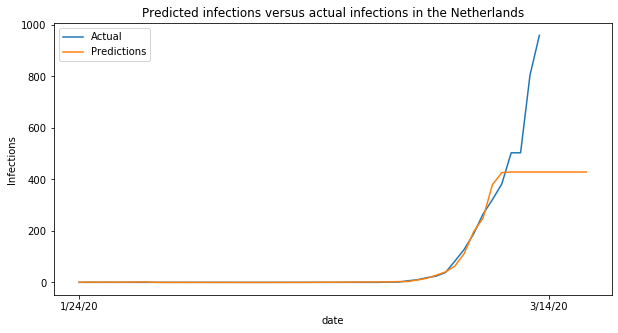

In [88]:
plot_preds_vs_actual(dates=dates, predictions=preds, labels=y_test)

In [89]:
preds

array([ 2.73654163e-01,  1.04179430e+00,  6.80815756e-01,  9.03252304e-01,
        7.27273881e-01,  8.78857911e-01,  1.13761926e+00,  1.39158678e+00,
        2.96682775e-01, -1.73768818e-01, -9.19941068e-02, -6.47763610e-02,
       -1.09244764e-01, -1.70797884e-01, -2.25880086e-01, -2.77870238e-01,
       -3.22953045e-01, -3.61135423e-01, -3.82267058e-01, -3.88681114e-01,
       -3.66990149e-01, -3.26422870e-01, -2.70420372e-01, -1.81838572e-01,
       -6.69872165e-02,  9.43742394e-02,  2.83990443e-01,  4.93969142e-01,
        7.17698038e-01,  9.46367681e-01,  1.16531253e+00,  1.37232256e+00,
        1.57374001e+00,  1.77350688e+00,  2.88415623e+00,  3.20755100e+00,
        9.11482239e+00,  1.54982386e+01,  2.75682831e+01,  4.02569160e+01,
        6.28653336e+01,  1.11994370e+02,  1.96383484e+02,  2.49197784e+02,
        3.78958435e+02,  4.25992371e+02,  4.28191345e+02,  4.28330414e+02,
        4.28349243e+02,  4.28351807e+02,  4.28352142e+02,  4.28352203e+02,
        4.28352203e+02,  